# <font color = 'blue'> __Lattice Graph Toy Example - Code__
We will consider the case of the time-homogeneous lattice, the time-inhomogeneous lattice that was presented in the examples of the paper.


## <font color = 'blue'> Directory
[1.1 Computation of Transition Matrix for $n \times n$ Lattice](#1.1)

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('whitegrid')


## <a id='TM_code'> <font color = 'blue'> __Computing Transition Matrix of $n \times n$ Lattice in the Time-Homogeneous Case__</a>

In [5]:
def lattice_constructor(n):
    transition_matrix = np.zeros((n ** 2, n ** 2)) # Initialises the transition matrix object
    for i in range(n ** 2):
        
        nb_unadjusted = np.array([i - n, i - 1, i + 1, i + n]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) & (nb_unadjusted < n ** 2)]) # Removes neighbours that are in undefined row entries
        if ((i % n) == 0) & (i != 0): # Removes neighbours that are in undefined columns
            nb.remove(i - 1)
            
        if ((i % n) == n - 1) & (i != (n ** 2) - 1): 
            nb.remove(i + 1)
            
        for j in nb:
            transition_matrix[i, j] = (1 / (len(nb)))
    
    return transition_matrix

In [11]:
m = 4 # We want to consider a mxm lattice
N = 20
num_states = m ** 2


""" Basics of the Markov Chain """
# Forward chain and initial distribution
P_base = lattice_constructor(m) # Makes the base transition matrix - will need to be changed to the form compatible with the functionality later
initial_dist = np.array([1 / num_states for i in range(num_states)]) # Initial distibution 

# Reverse process
from tpt_gc import calc_reverse_process, calc_forward_comms, calc_backward_comms

# The following step is to make P_tim_hom compatible with the reverse_process function:
P = np.zeros((N, num_states, num_states))
P[0:N] = P_base # applying numpy broadcasting feature 
P_reverse, distributions = calc_reverse_process(P, initial_dist, N)


""" Transition path theory"""
# Reactant and target sets:
A = [0] 
B = [15] 

# Forward and backward committors
forward_comms = calc_forward_comms(P, N, A, B)
backward_comms = calc_backward_comms(P_reverse, N, A, B)

"""Calculating transition statistics"""
from tpt_gc import calc_reactive_dist, calc_cond_reactive_dist, calc_prob_current, calc_effec_current

reactive_dist = calc_reactive_dist(distributions, forward_comms, backward_comms)
cond_reactive_dist = calc_cond_reactive_dist(reactive_dist)
prob_current = calc_prob_current(forward_comms, backward_comms, distributions, P)
effec_current = calc_effec_current(prob_current)

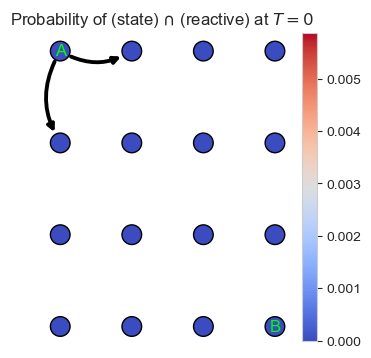

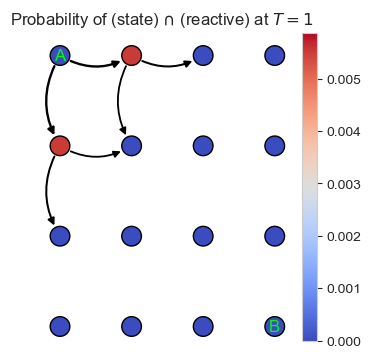

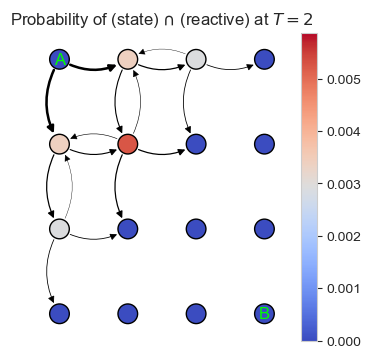

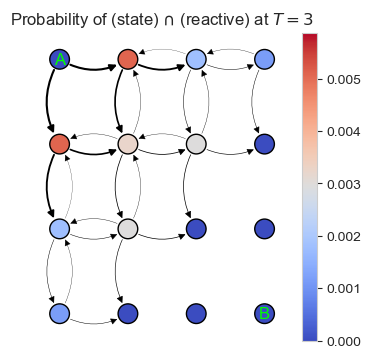

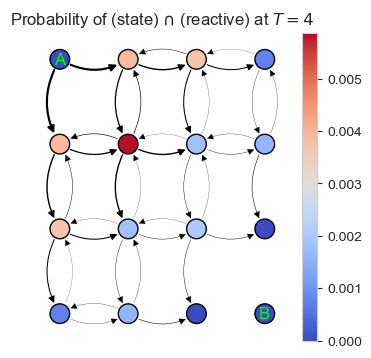

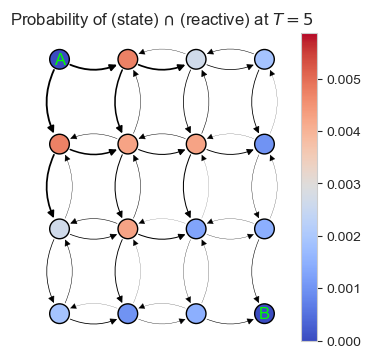

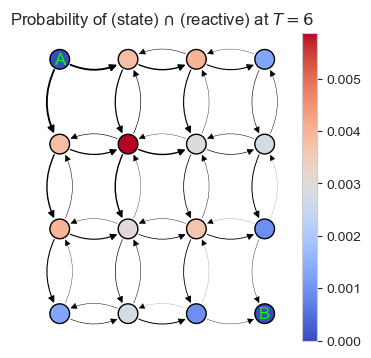

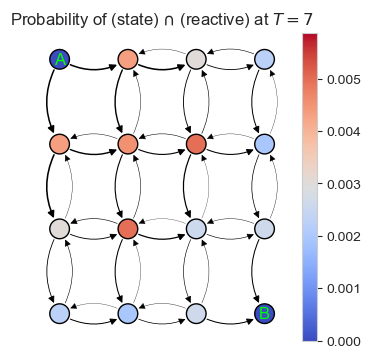

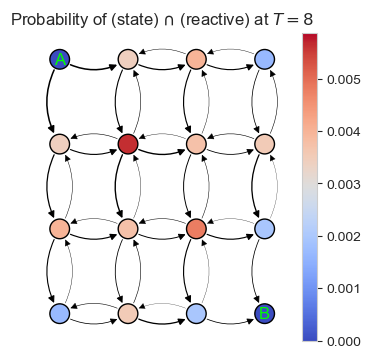

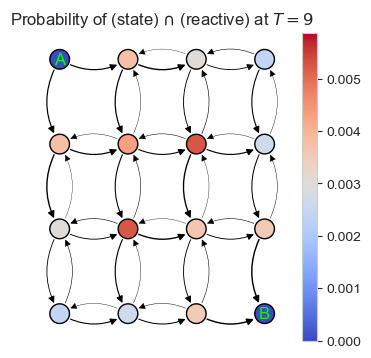

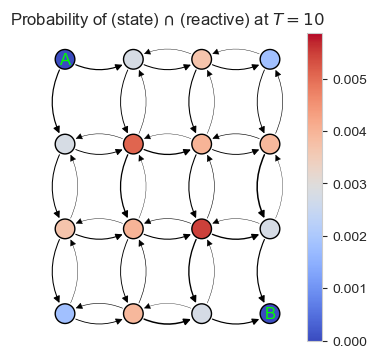

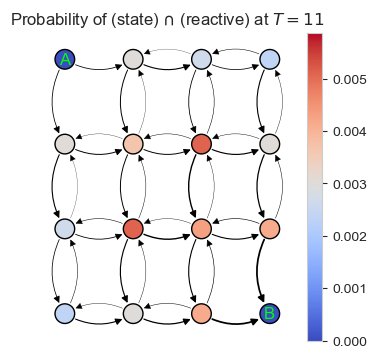

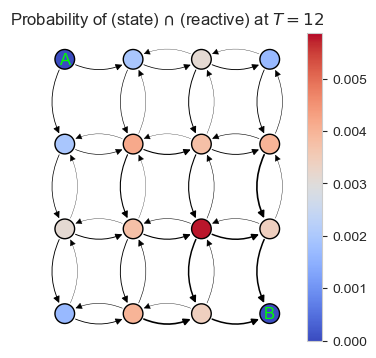

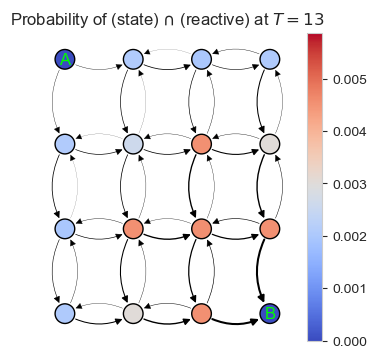

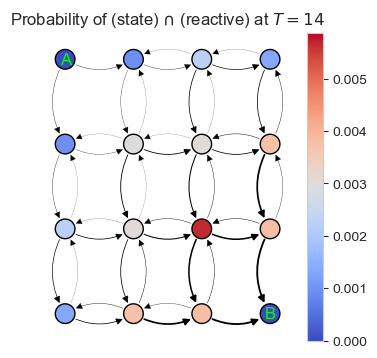

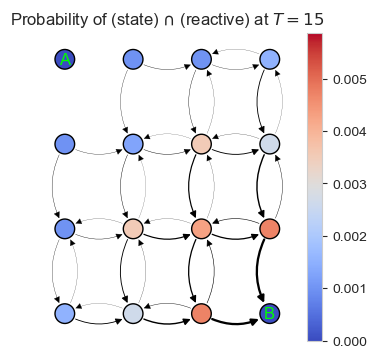

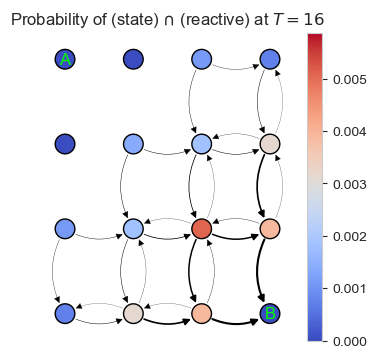

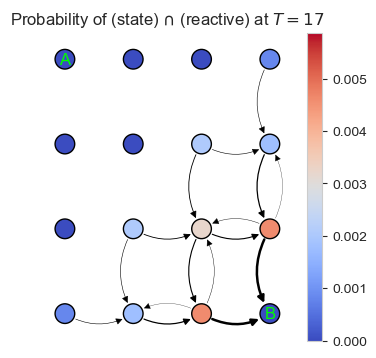

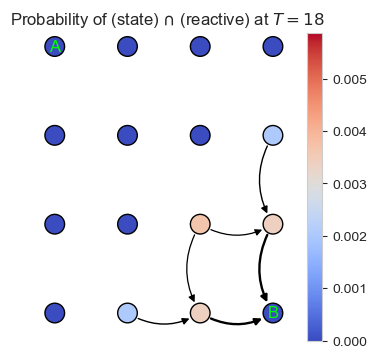

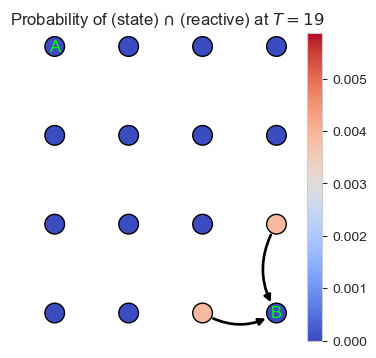

In [15]:
# Plotting the evolution of the reactive distributions
import networkx as nx
from lattice_visual import draw_reactive_distributions

draw_reactive_distributions(m, N, A, B, reactive_dist, prob_current)
#cond_rd_calculator(reactive_distributions)

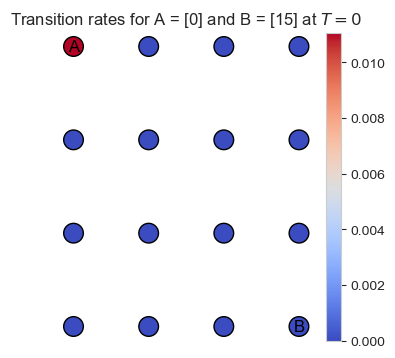

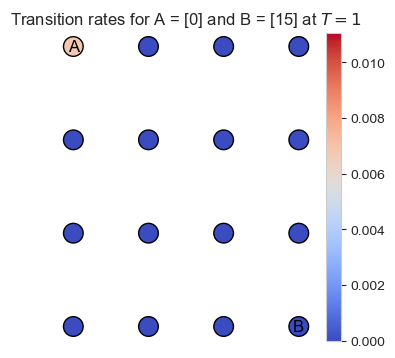

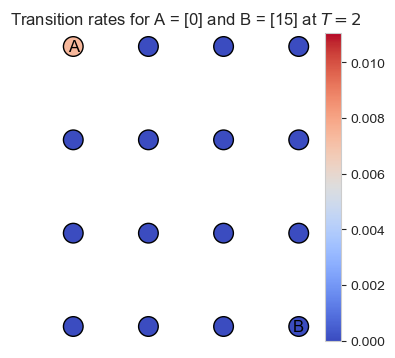

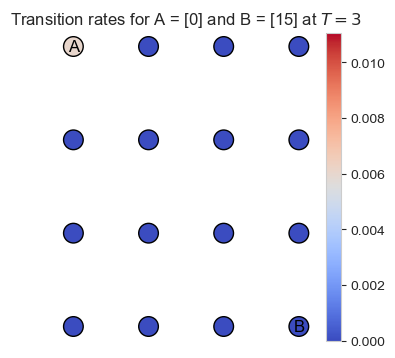

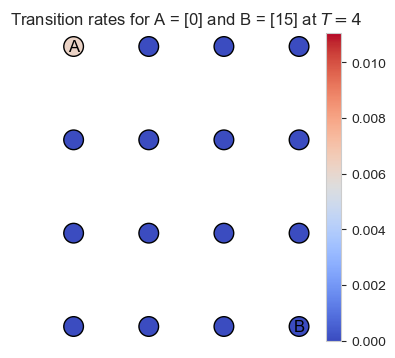

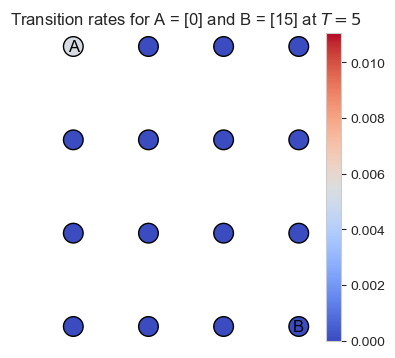

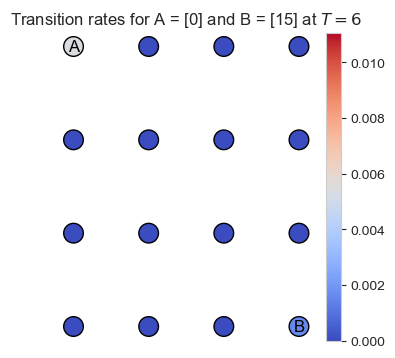

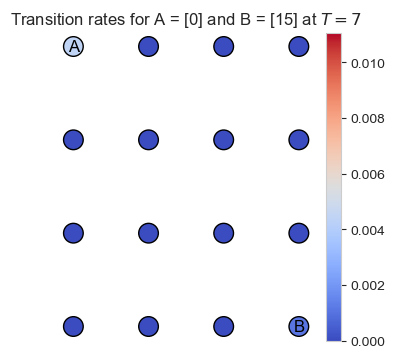

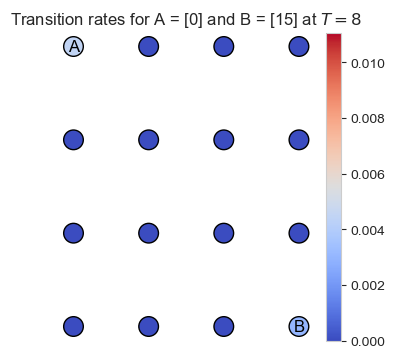

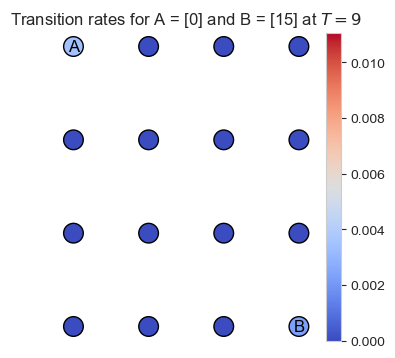

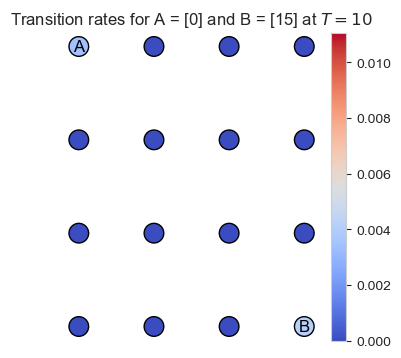

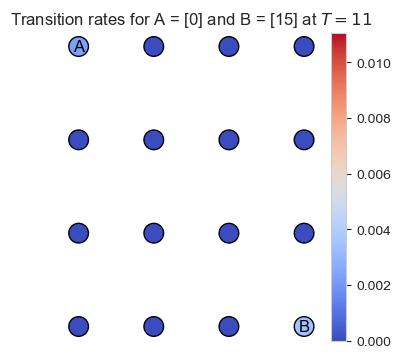

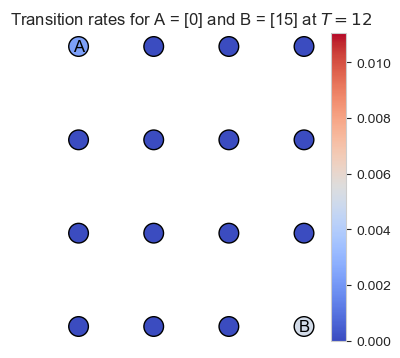

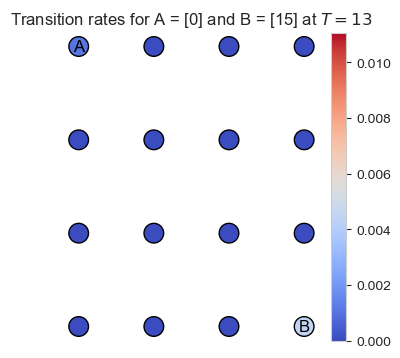

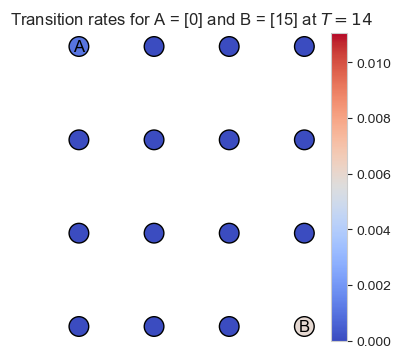

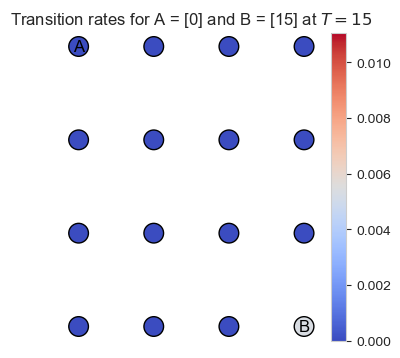

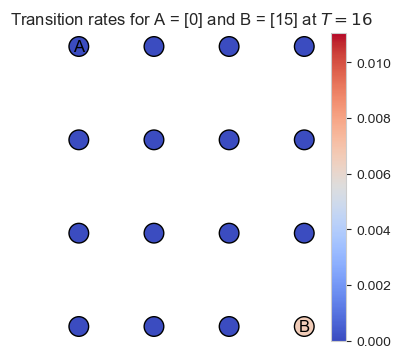

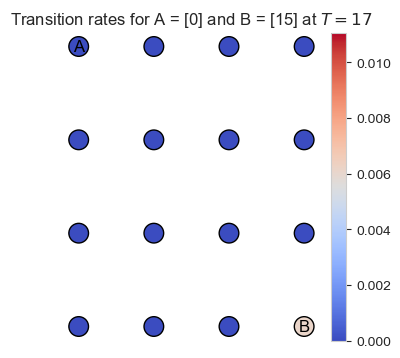

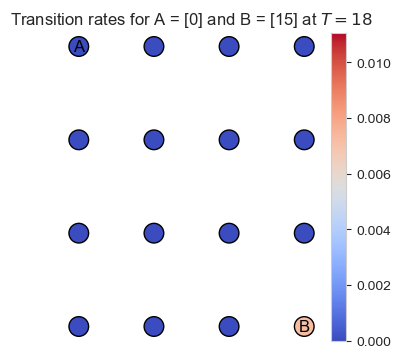

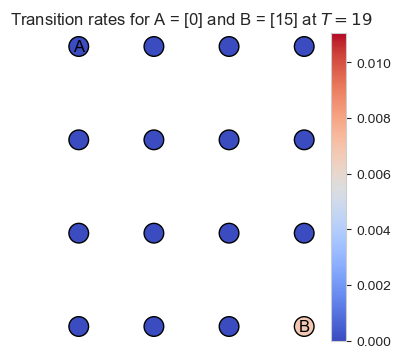

0.07063762550109554 0.07063762550109554


In [78]:
from tpt_gc import calc_rate
from lattice_visual import rates_visualisation

rates = calc_rate(prob_current, A, B)
rates_visualisation(m, N, A, B, rates)

print(rates[:, A].sum(), rates[:, B].sum())

In [77]:
class WidestWeight:
    def __init__(self, weight, inverse=True):
        self._value = 1 / weight if inverse else weight
    def __add__(self, weight):
        weight = weight._value if type(weight) == WidestWeight else weight
        return WidestWeight(max(self._value, weight), inverse=False)
    def __radd__(self, weight):
        return self.__add__(weight)
    def __lt__(self, weight):
        weight = weight._value if type(weight) == WidestWeight else weight
        return self._value < weight
    @staticmethod
    def nx_weight(u, v, data):
        return WidestWeight(data['weight'])

def create_meta_graph_matrix(effec_current): 

    # there are N entries from [|0, N-1|]
    N = len(effec_current) 
    num_states = len(effec_current[0]) 
    num_states_meta = (N + 1) * num_states 
    
    weight_matrix = np.zeros( (num_states_meta, num_states_meta) ) # Initialise the weight matrix for edges in the meta-graph.

    for n in range(N): 
        # The row entry of the weight matrix is where the current flows from, and the column entry of the weight matrix is where the current
        # flows to. The effective current from i to j at time n, in the meta-graph, is the effective current from i at time n to j at time n+1. 
        # The weight matrix is arranged so that all the states at time n come before the states at time n+1. 
        if n < N - 1:
            weight_matrix[n*num_states:(n+1)*num_states, (n+1)*num_states:(n+2)*num_states] = effec_current[n]
        else:
            weight_matrix[n*num_states:(n+1)*num_states, (n+1)*num_states:] = effec_current[n]
    return weight_matrix


def build_super_source_target(meta_graph_matrix, meta_A, meta_B):
    """
    

    Parameters
    ----------
    meta_graph_matrix : TYPE
        The matrix of meta_graph_edges
    meta_A : TYPE
        DESCRIPTION.
    meta_B : TYPE
        DESCRIPTION.

    Returns
    -------
    appended_matrix : 
        The new meta-graph, with effective current 1 from a single super-source to all source nodes, 
        and effective current 1 from all target nodes to a single super-target node.
    """
    # Initialises the new meta-graph matrix with a single source and target. 
    appended_matrix = np.zeros((len(meta_graph_matrix) + 2, len(meta_graph_matrix) + 2)) 
    
    # Fill the top nxn corner with the edges in the meta-graph
    appended_matrix[0: len(meta_graph_matrix), 0: len(meta_graph_matrix)] = meta_graph_matrix
    appended_matrix[-2, meta_A] = 1
    appended_matrix[meta_B, -1] = 1
    
    return appended_matrix

A_meta = [n * num_states + A[0] for n in range(N + 1)]
B_meta = [n * num_states + B[0] for n in range(N + 1)]

meta_graph_matrix = create_meta_graph_matrix(effec_current)
super_targetsource = build_super_source_target(meta_graph_matrix, A_meta, B_meta)
meta_G = nx.from_numpy_array(super_targetsource, create_using=nx.DiGraph)

widest_path = nx.shortest_path(meta_G, len(meta_graph_matrix), len(meta_graph_matrix) + 1, weight=WidestWeight.nx_weight)
widest_path.pop(0), widest_path.pop(-1)
path = [(state // num_states, state % num_states) for state in widest_path]
print(path)

# Calculate the bottleneck
def find_bottleneck():
    bottleneck = np.nan
    min_current = np.inf
    for i in range(len(widest_path) - 1):
        current = meta_graph_matrix[widest_path[i], widest_path[i+1]]
        if current < min_current:
            min_current = current
            bottleneck = i

    return (np.divmod(widest_path[i], num_states), np.divmod(widest_path[i+1], num_states)), min_current 

bottleneck, min_current = find_bottleneck()
print(bottleneck)
print(min_current)

[(2, 0), (3, 4), (4, 5), (5, 6), (6, 10), (7, 11), (8, 15)]
((7, 11), (8, 15))
0.0007052951388888886


## <a id='absstate'> <font color = 'blue'> __TPT on $m \times m$ Lattice with Inaccessible States__ </a>

In [ ]:
def bottleneck_lattice_constructor(n, cut):
    
    transition_matrix = np.zeros((n ** 2, n ** 2)) # Initialises the transition matrix object
    for i in range(n**2):

        if i in cut: 
            transition_matrix[i, i] = 1
            continue

        if i % n == 0:
            nb_unadjusted = np.array([i - n,  i + 1, i + n]) # Removes left neighbour if i is on the left border
        elif i % n == n - 1:
            nb_unadjusted = np.array([i - n,  i - 1, i + n]) # Removes right neighbour if i is on the right border
        else:
            nb_unadjusted = np.array([i - n, i - 1, i + 1, i + n]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) 
                  & (nb_unadjusted < n ** 2) 
                  & ~np.in1d( nb_unadjusted, np.array(cut) )])    # Removes neighbours that are on undefined entries

#        if ((i % n) == 0) & (i != 0): # Removes left neighbour if i is on the left border
#            nb.remove(i - 1)
            
#        if ((i % n) == n - 1) & (i != (n ** 2) - 1): # Removes right neighbour if i is on the right border
#            nb.remove(i + 1)
            
        for j in nb:
            transition_matrix[i, j] = (1 / (len(nb)))
    
    return transition_matrix

"""Creating the new Markov Chain"""
m = 4
N = 20
num_states = m ** 2

states_to_cut = [6,10]
P = bottleneck_lattice_constructor(n, states_to_cut)
initial_dist = np.array([1 / num_states for i in range(num_states)])

# Reverse chain 
Q_reverse, distributions_bn = reverse_process(Q, pi_0_bn, N)

In [ ]:
from tpt_gc import reverse_process, calc_forward_comm, calc_backward_comm, calc_prob_current, calc_reactive_dist


forward_comms, backward_comms = calc_forward_comm(Q, N, A, B), calc_backward_comm(Q_reverse, N, A, B)
reactive_distributions_bn = calc_reactive_dist(distributions_bn, q_plus_bn, q_minus_bn)
prob_current_bn = calc_prob_current(q_plus_bn, q_minus_bn, distributions_bn, Q)

## <a id='2.2'> <font color = 'blue'> 2.2 Visuals of the Bottleneck</a> 
### <a id='2.2.1'> <font color = 'blue'> 2.2.1 Lattice Colour-Coded Visuals </a> 
In this section we plot the distributions on the network using colour-coding.

In [ ]:
from lattice_visual import draw_reactive_distributions

draw_reactive_distributions(n, N, A, B, reactive_distributions_bn, prob_current_bn)

In [ ]:
from tpt_gc import rate_calculator
from lattice_visual import rates_visualisation

rates_bn = rate_calculator(prob_current_bn, A, B)

rates_visualisation(n, N, A, B, rates_bn)

# <a id='BNMetzner'> <font color='blue'> __Metzner Bottleneck__ </a>
We follow the characteristation of bottlenecks according to Metzner (2007). 


In [51]:
from tpt_gc import calc_effec_current

effec_current = calc_effec_current(prob_current)

def create_meta_graph_matrix(effec_current): 

    # there are N entries from [|0, N-1|]
    N = len(effec_current) 
    num_states = len(effec_current[0]) 
    num_states_meta = (N + 1) * num_states 
    
    weight_matrix = np.zeros( (num_states_meta, num_states_meta) ) # Initialise the weight matrix for edges in the meta-graph.

    for n in range(N): 
        # The row entry of the weight matrix is where the current flows from, and the column entry of the weight matrix is where the current
        # flows to. The effective current from i to j at time n, in the meta-graph, is the effective current from i at time n to j at time n+1. 
        # The weight matrix is arranged so that all the states at time n come before the states at time n+1. 
        if n < N - 1:
            weight_matrix[n*num_states:(n+1)*num_states, (n+1)*num_states:(n+2)*num_states] = effec_current[n]
        else:
            weight_matrix[n*num_states:(n+1)*num_states, (n+1)*num_states:] = effec_current[n]
    return weight_matrix


def build_super_source_target(meta_graph_matrix, meta_A, meta_B):
    """
    

    Parameters
    ----------
    meta_graph_matrix : TYPE
        The matrix of meta_graph_edges
    meta_A : TYPE
        DESCRIPTION.
    meta_B : TYPE
        DESCRIPTION.

    Returns
    -------
    appended_matrix : 
        The new meta-graph, with effective current 1 from a single super-source to all source nodes, 
        and effective current 1 from all target nodes to a single super-target node.
    """
    # Initialises the new meta-graph matrix with a single source and target. 
    appended_matrix = np.zeros((len(meta_graph_matrix) + 2, len(meta_graph_matrix) + 2)) 
    
    # Fill the top nxn corner with the edges in the meta-graph
    appended_matrix[0: len(meta_graph_matrix), 0: len(meta_graph_matrix)] = meta_graph_matrix
    appended_matrix[-2, meta_A] = 1
    appended_matrix[meta_B, -1] = 1
    
    return appended_matrix

A_meta = [n * num_states + A[0] for n in range(N + 1)]
B_meta = [n * num_states + B[0] for n in range(N + 1)]

meta_graph_matrix = create_meta_graph_matrix(effec_current)
super_targetsource = build_super_source_target(meta_graph_matrix, A_meta, B_meta)
meta_G = nx.from_numpy_array(super_targetsource, create_using=nx.DiGraph)

print(nx.is_directed_acyclic_graph(meta_G)) # Sanity check - should be a directed acyclic graph

True


In [11]:
# The following code was imported from <insert github link here>
class WidestWeight:
    def __init__(self, weight, inverse=True):
        self._value = 1 / weight if inverse else weight
    def __add__(self, weight):
        weight = weight._value if type(weight) == WidestWeight else weight
        return WidestWeight(max(self._value, weight), inverse=False)
    def __radd__(self, weight):
        return self.__add__(weight)
    def __lt__(self, weight):
        weight = weight._value if type(weight) == WidestWeight else weight
        return self._value < weight
    @staticmethod
    def nx_weight(u, v, data):
        return WidestWeight(data['weight'])

#widest_paths = nx.all_shortest_paths(meta_G, len(meta_graph_matrix), len(meta_graph_matrix) + 1, weight=WidestWeight.nx_weight)
#print(nx.shortest_path_length(meta_G, source=len(meta_graph_matrix), target=len(meta_graph_matrix) + 1, weight=WidestWeight.nx_weight)._value)

# <a id='NonTH'> <font color='blue'> __Calculating Transition Matrix for the Non-Time-Homogeneous (TH) Chain__ </a>

In this section we will create a non-time-homogeneous lattice. 

The lattice can be described with moving with equal probability to all its neighbours, except the states $(1,2), (2,2)$ are removed from the lattice.

In [2]:
def non_timehom_lattice(m, cut):

    # m = dimensions of lattice
    transition_matrix = np.zeros((m ** 2, m ** 2)) 
    for i in range(m ** 2):
        
        if i in cut: 
            transition_matrix[i, i] = 1
            continue
    
        if i % m == 0:
            nb_unadjusted = np.array([i - m,  i + 1, i + m]) # Removes left neighbour if i is on the left border
        elif i % m == m - 1:
            nb_unadjusted = np.array([i - m,  i - 1, i + m]) # Removes right neighbour if i is on the right border
        else:
            nb_unadjusted = np.array([i - m, i - 1, i + 1, i + m]) # Calculate the potential neighbours
        nb = list(nb_unadjusted[(nb_unadjusted >= 0) 
                  & (nb_unadjusted < m ** 2) 
                  & ~np.in1d( nb_unadjusted, np.array(cut) )])    # Removes neighbours that are on undefined entries

        for j in nb:
                transition_matrix[i, j] = (1 / (len(nb)))

    return transition_matrix

In [5]:
"""Markov Chain"""
# Setting up state space and time 
m = 4
num_states = m ** 2
N = 20

# Transition matrices
first_half_matrix = non_timehom_lattice(m, [6, 10, 14])
second_half_matrix = non_timehom_lattice(m, [2,6,10])
cutoff_time = 9

P = np.zeros((N, num_states, num_states))
P[:cutoff_time] = first_half_matrix
P[cutoff_time:] = second_half_matrix
initial_dist = [1 / num_states for i in range(num_states)]

# Reverse process
from tpt_gc import calc_reverse_process
P_reverse, dist = calc_reverse_process(P, initial_dist, N)


"""
TPT
"""
# Reactant and Target Set
A = [4]
B = [11]

# Committors and transition statistics
from tpt_gc import calc_forward_comms, calc_backward_comms, calc_prob_current, calc_reactive_dist, calc_effec_current
forward_comms, backward_comms = calc_forward_comms(P, N, A, B), calc_backward_comms(P_reverse, N, A, B)
reactive_dist = calc_reactive_dist(dist, forward_comms, backward_comms)
prob_current = calc_prob_current(forward_comms, backward_comms, dist, P)
effec_current = calc_effec_current(prob_current)

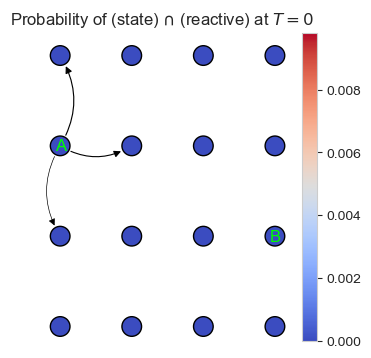

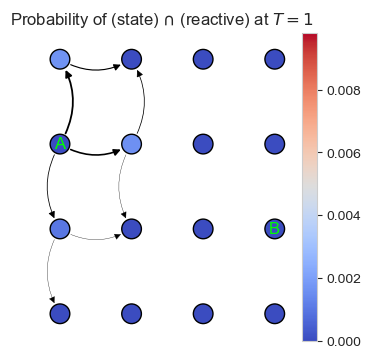

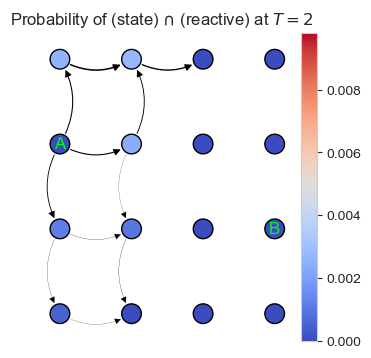

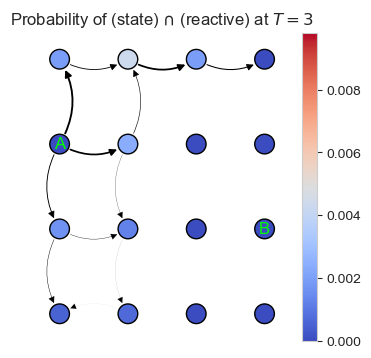

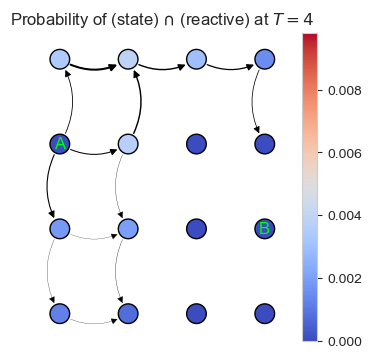

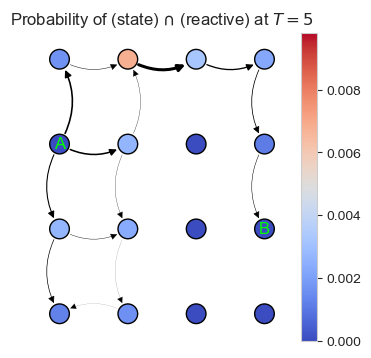

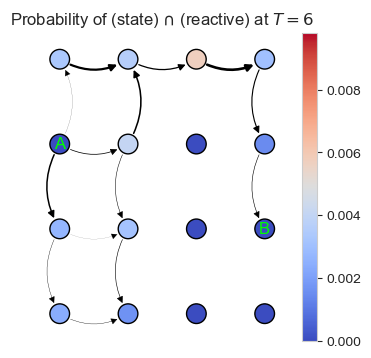

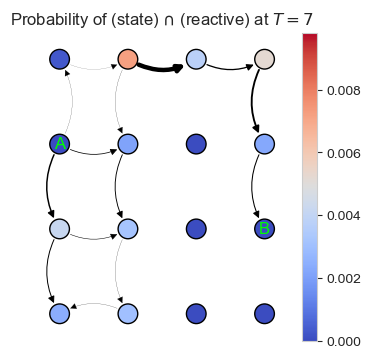

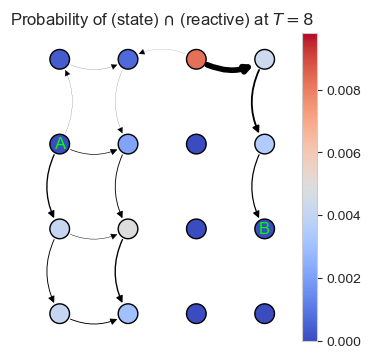

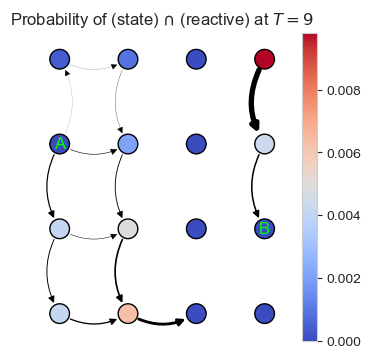

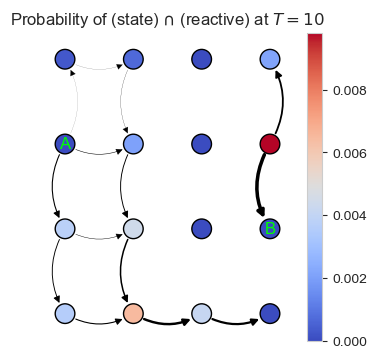

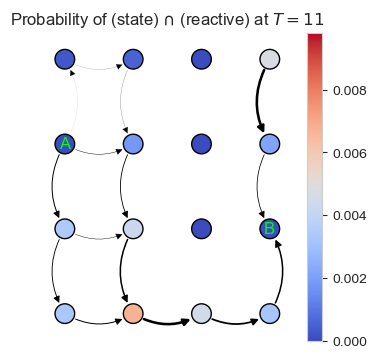

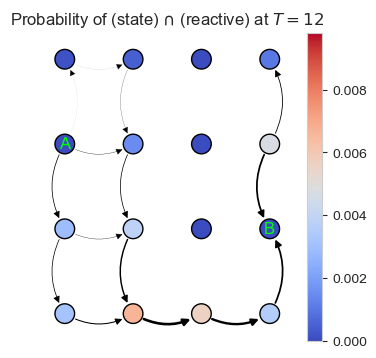

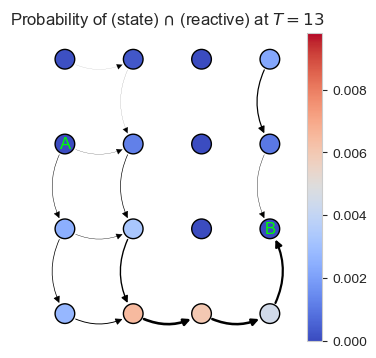

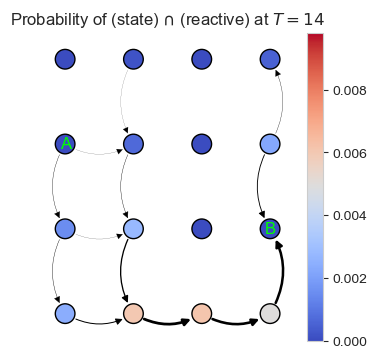

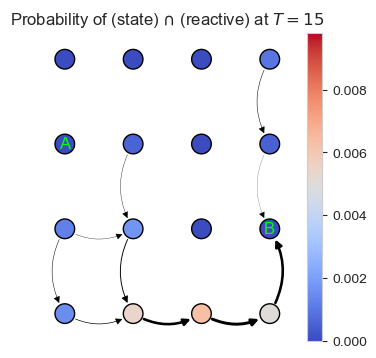

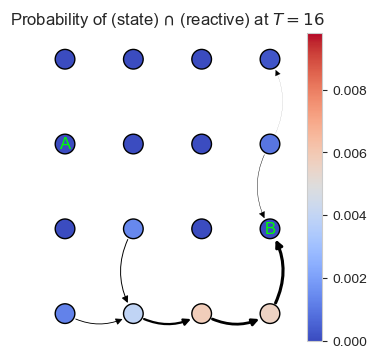

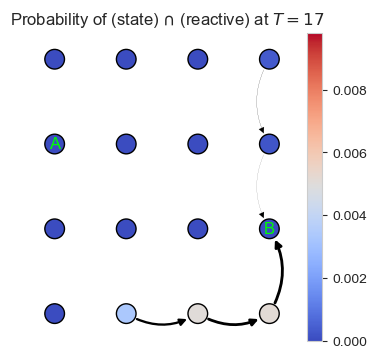

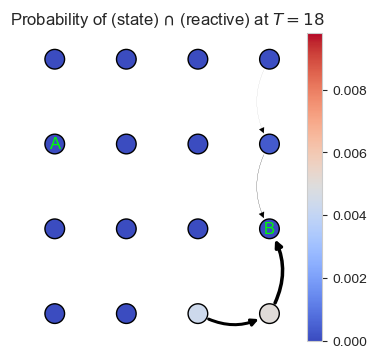

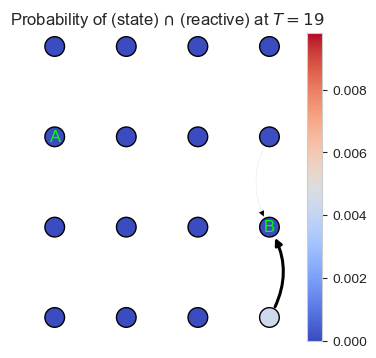

In [13]:
# Visualise the distributions
from lattice_visual import draw_reactive_distributions

draw_reactive_distributions(m, N, A, B, reactive_dist, effec_current)

In [51]:
from bottleneck_tpt import build_meta_graph_matrix, build_meta_source_target, build_super_source_target

# Creation of the meta-graph with non-timehom
meta_graph_matrix = build_meta_graph_matrix(effec_current)
meta_A, meta_B = build_meta_source_target(N, num_states, A, B)
super_targetsource = build_super_source_target(meta_graph_matrix, meta_A, meta_B)
meta_G = nx.from_numpy_array(super_targetsource, create_using=nx.DiGraph)

# Calculating the widest path
widest_path = nx.shortest_path(meta_G, len(meta_graph_matrix), len(meta_graph_matrix) + 1, weight=WidestWeight.nx_weight)
widest_path.pop(0), widest_path.pop(-1)
path = [(state // num_states, state % num_states) for state in widest_path]
print(path)

# Calculate the bottleneck
def find_bottleneck():
    bottleneck = np.nan
    min_current = np.inf
    for i in range(len(widest_path) - 1):
        current = meta_graph_matrix[widest_path[i], widest_path[i+1]]
        if current < min_current:
            min_current = current
            bottleneck = i

    return (bottleneck, bottleneck +1 ), min_current 

bottleneck, min_current = find_bottleneck()
print(bottleneck)
print(min_current)

[(5, 4), (6, 0), (7, 1), (8, 2), (9, 3), (10, 7), (11, 11)]
(0, 1)
0.002337402609190207
